In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from keras.models import Model
from keras import Input
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K



# **Определение функций**

In [69]:
# Функция fit_predict для списка learnig_rate с выводом отчета о классификации, матрицы ошибок, графика валидации.
def train_and_report(model, lr_list, x_train, y_train, val_data, y_test, x_test,
                     loss,  metrics, optimizer=optimizers.Adam(),
                     batch_size=64, epochs=100, verbose=1, patience=50):
  global model_loaded
  import tensorflow.keras.backend as K
  import time
  for lr in lr_list:
    
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    K.set_value(model.optimizer.learning_rate, lr)

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='bestmodel.h5',
            save_best_only=True,
            monitor='val_accuracy',
            verbose=verbose),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=patience,
            verbose=verbose)
        ]
    
    start_time = time.time()

    history = model.fit(x_train,
                        y_train,
                        verbose=verbose,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=val_data)
    
    accuracy = round(accuracy_score(y_test,tf.argmax(input=model.predict(x_test), axis=1)),4)
    print('#########################')
    print('#########################')
    print(f'Learning_rate: {lr}')
    print("--- %s seconds ---" % (time.time() - start_time))

    print('Last epoch (model):')
    print(classification_report(y_test,tf.argmax(input=model.predict(x_test), axis=1)))
    print(confusion_matrix(y_test,tf.argmax(input=model.predict(x_test), axis=1)))
    print(f'Accuracy: {accuracy}')
    model_loaded = tf.keras.models.load_model('bestmodel.h5')
    accuracy = round(accuracy_score(y_test,tf.argmax(input=model_loaded.predict(x_test), axis=1)),4)
    print('Best epoch (model_loaded):')
    print(classification_report(y_test,tf.argmax(input=model_loaded.predict(x_test), axis=1)))
    print(confusion_matrix(y_test,tf.argmax(input=model_loaded.predict(x_test), axis=1)))
    print(f'Accuracy: {accuracy}')

    #model.save(f'/content/gdrive/MyDrive/pet-transformator/Keras/1.{i}.Dense_(40,relu,{lr})_acc_{accuracy}.h5')
    #i += 1

    acc_ = history.history['accuracy']
    val_acc_ = history.history['val_accuracy']

    epochs_ = range(1, len(acc_) +1)
    plt.figure(figsize=(20,5))
    plt.plot(epochs_, acc_, 'bo', label='Training accuracy')
    plt.plot(epochs_, val_acc_, 'b', label='Validation accuracy')
    plt.title(f'Learning rate: {lr}, Accuracy: {accuracy}', fontsize = 25)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([.70,.99])
    plt.legend()


# Функция поиска оптимального learning_rate
!cp /content/gdrive/MyDrive/pet-transformator/Keras/keras_lr_finder/lr_finder.py /content
tests = [
  (optimizers.Adam(), 'Adam optimizer'),
  (optimizers.RMSprop(), 'RMSpRop optimizer')
]
def Find_Lr(model, x_train, y_train, start_lr=0.00001, end_lr=1, batch_size=64, epochs=100, verbose=1):
    from lr_finder import LRFinder
    test_learning_rates = []
    test_losses = []
    test_loss_changes = []
    labels = []


    for test_optimizer, label in tests:
    
        model.compile(optimizer=test_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        
        lr_finder = LRFinder(model)

        outputs = lr_finder.find(x_train, 
                             y_train, 
                             start_lr=start_lr, 
                             end_lr=end_lr, 
                             batch_size=batch_size, 
                             epochs=epochs, verbose=verbose)

        learning_rates = lr_finder.lrs
        losses = lr_finder.losses
        loss_changes = []

        moving_average = 20

        for i in range(moving_average, len(learning_rates)):
            loss_changes.append((losses[i] - losses[i - moving_average]) / moving_average)

        test_learning_rates.append(learning_rates)
        test_losses.append(losses)
        test_loss_changes.append(loss_changes)
        labels.append(label)

    plt.figure(figsize=(20,5))
    for i in range(0, len(test_learning_rates)):
      plt.plot(test_learning_rates[i][moving_average:], test_loss_changes[i], label=labels[i])
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.ylabel('loss delta')
    plt.xlabel('learning rate (log scale)')
    plt.title('Results for Learning Rate Range Test / Loss Deltas for Learning Rate')
    plt.show()

    # Generate plot for Loss Values
    plt.figure(figsize=(20,5))
    for i in range(0, len(test_learning_rates)):
      plt.plot(test_learning_rates[i], test_losses[i], label=labels[i])
    plt.xscale('log')
    plt.legend(loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('learning rate (log scale)')
    plt.title('Results for Learning Rate Range Test / Loss Values for Learning Rate')
    plt.show()

    return test_loss_changes, test_learning_rates

# **Загрузка и подготовка данных**

In [4]:
X = np.load('/content/gdrive/MyDrive/pet-transformator/Keras/All_times_array.npy')
X_scaled = np.load('/content/gdrive/MyDrive/pet-transformator/Keras/All_times_scaled_array.npy')
X_timescaled = np.load('/content/gdrive/MyDrive/pet-transformator/Keras/All_times_timescaled_array.npy')
train_labels = pd.read_csv("/content/gdrive/MyDrive/pet-transformator/Keras/train.csv")
train_labels.sort_values("id", inplace = True)
train_labels.set_index("id", inplace = True)
y = train_labels['category'].replace([1, 2, 3, 4], [0, 1, 2, 3])
print(f"X shape: {X.shape}")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"X_timescaled shape: {X_timescaled.shape}")
print(f"y shape: {y.shape}")

X shape: (2100, 420, 4)
X_scaled shape: (2100, 420, 4)
X_timescaled shape: (2100, 105, 4)
y shape: (2100,)


In [109]:
x_tr, x_test, y_tr, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size = 0.15, random_state = 1, stratify = y_tr)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")


x_train: (1428, 420, 4)
y_train: (1428, 4)
x_val: (252, 420, 4)
y_val: (252, 4)
x_test: (420, 420, 4)
y_test: (420,)


In [50]:
x_train1 = x_train.reshape(x_train.shape[0], 420, 4, 1)
x_val1 = x_val.reshape(x_val.shape[0], 420, 4, 1)
x_test1 = x_test.reshape(x_test.shape[0], 420, 4, 1)

In [ ]:
x_train1.shape

(1428, 420, 4, 1)

# **Двумерные сверточные сети, многомерный ряд без преобразований**

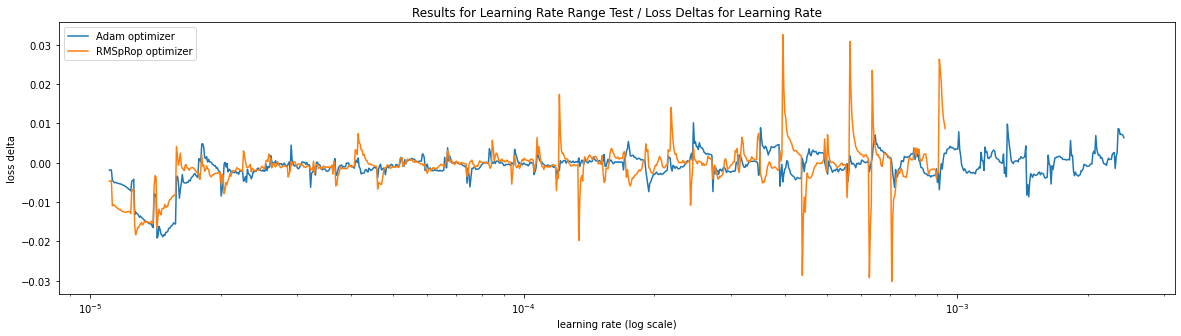

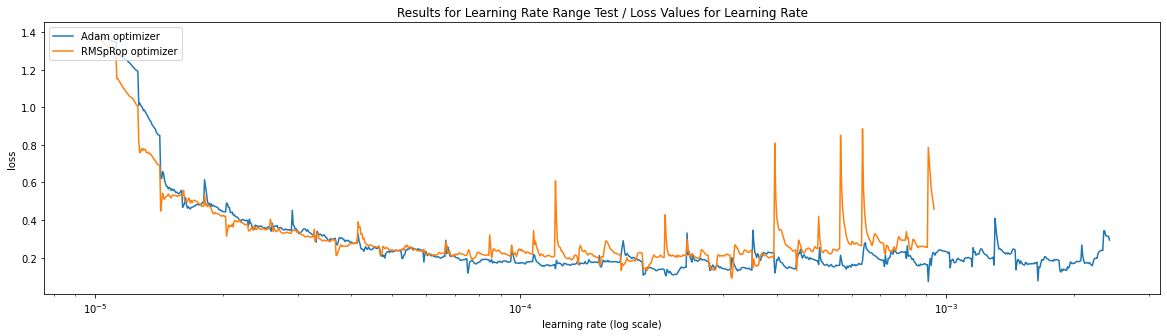

In [55]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4,4), activation='relu', input_shape=(420, 4, 1)))
model.add(layers.MaxPooling2D((1,1)))
model.add(layers.Flatten())
model.add(layers.Dense(6500, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
loss_changes, learning_rates = Find_Lr(model=model, x_train=x_train1, y_train=y_train,
                                                 start_lr=0.00001, end_lr=1, batch_size=64, epochs=100, verbose=0)

In [ ]:
for value in sorted(list(enumerate(loss_changes[1])), key=lambda x: x[1])[:50]:
    print(learning_rates[1][value[0]], end=' ')
    print(f"({value[1]})")

#########################
#########################
Learning_rate: 1.0156e-05
--- 202.4442174434662 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       341
           1       0.89      0.94      0.92        18
           2       0.89      0.70      0.78        23
           3       0.69      0.76      0.72        38

    accuracy                           0.93       420
   macro avg       0.86      0.84      0.85       420
weighted avg       0.93      0.93      0.93       420

[[329   0   2  10]
 [  0  17   0   1]
 [  5   0  16   2]
 [  7   2   0  29]]
Accuracy: 0.931
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       341
           1       1.00      0.78      0.88        18
           2       0.85      0.48      0.61        23
           3       0.68      0.79      0.73        38

    accuracy                           0.

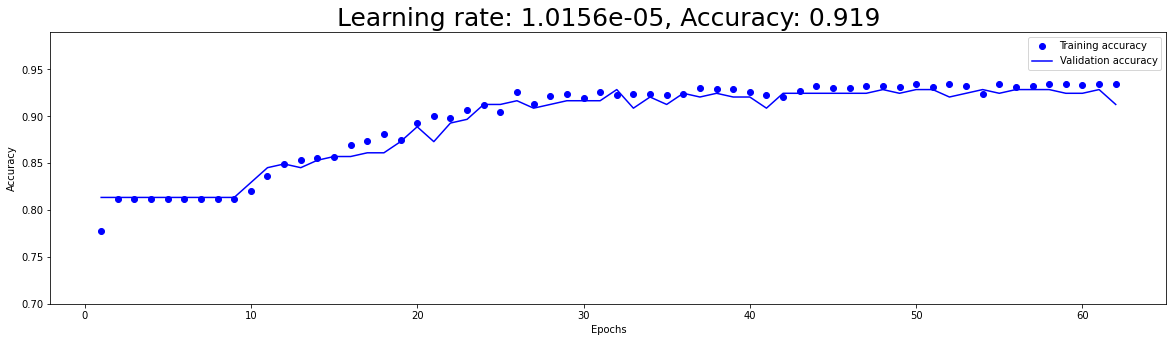

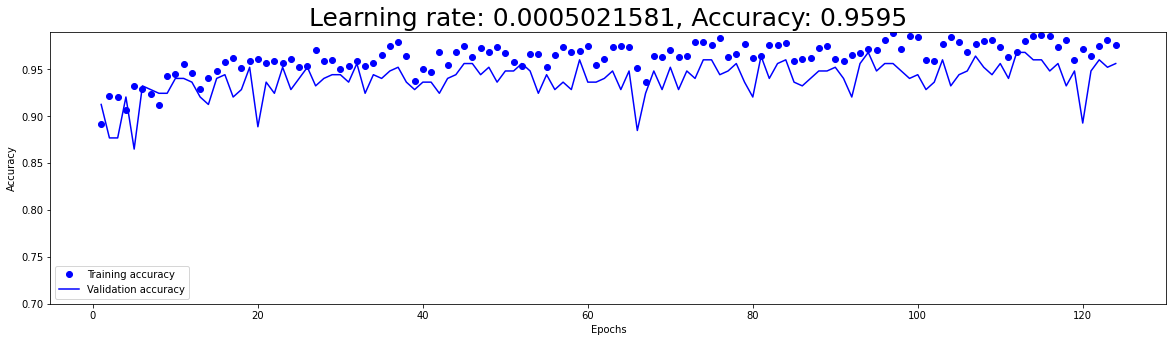

In [56]:
train_and_report(model, lr_list=[1.0156e-05, 0.0005021581], x_train=x_train1, y_train=y_train, val_data=(x_val1, y_val), 
                 y_test=y_test, x_test=x_test1, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=500, verbose=0)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4,4), activation='relu', input_shape=(420, 4, 1)))
model.add(layers.MaxPooling2D((1,1)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6500, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
loss_changes, learning_rates = Find_Lr(model=model, x_train=x_train1, y_train=y_train,
                                                 start_lr=0.00001, end_lr=1, batch_size=64, epochs=100, verbose=0)

#########################
#########################
Learning_rate: 1.14e-05
--- 41.56750679016113 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       341
           1       1.00      0.89      0.94        18
           2       0.90      0.78      0.84        23
           3       0.77      0.87      0.81        38

    accuracy                           0.95       420
   macro avg       0.91      0.88      0.89       420
weighted avg       0.96      0.95      0.96       420

[[334   0   1   6]
 [  0  16   0   2]
 [  3   0  18   2]
 [  4   0   1  33]]
Accuracy: 0.9548
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       341
           1       0.94      0.89      0.91        18
           2       0.90      0.78      0.84        23
           3       0.76      0.76      0.76        38

    accuracy                           0.9

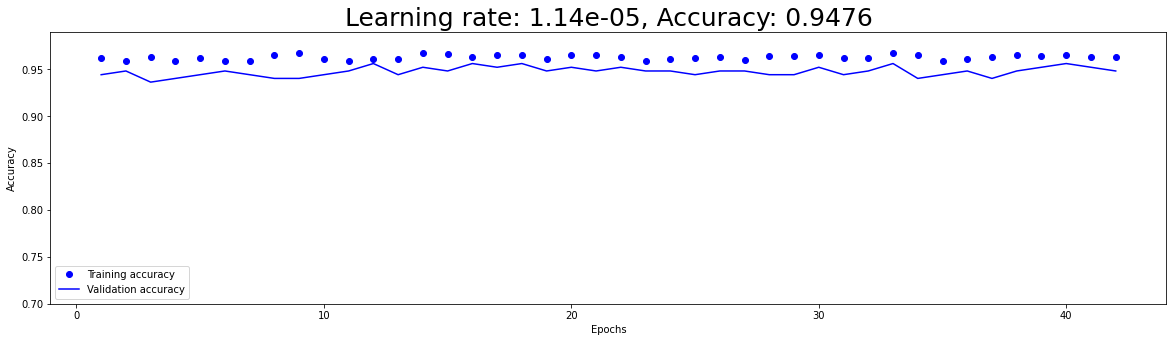

In [63]:
train_and_report(model, lr_list=[1.14e-05], x_train=x_train1, y_train=y_train, val_data=(x_val1, y_val), 
                 y_test=y_test, x_test=x_test1, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=500, verbose=0)

In [64]:
model_loaded.save('/content/gdrive/MyDrive/pet-transformator/Keras/3.1.CONV2D(4x4)_acc_0.9476.h5')

# **CNN1D, 4 входа, без преобразований**

In [65]:
x_train_list = [x_train[:,:,0], x_train[:,:,1], x_train[:,:,2], x_train[:,:,3]]
x_val_list = [x_val[:,:,0], x_val[:,:,1], x_val[:,:,2], x_val[:,:,3]]
x_test_list = [x_test[:,:,0], x_test[:,:,1], x_test[:,:,2], x_test[:,:,3]]

In [66]:
filters = 64
kernel_size = 9
pool_size = 2



h2o_input = Input(shape=(420, 1), name='H2')
h2o = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h2o_input)
h2o = layers.MaxPooling1D(pool_size=pool_size)(h2o)
#h2o = layers.GlobalMaxPooling1D()(h2o)
#h2o = layers.Flatten()(h2o)

co_input = Input(shape=(420, 1), name='CO')
co = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(co_input)
co = layers.MaxPooling1D(pool_size=pool_size)(co)
#co = layers.GlobalMaxPooling1D()(co)
#co = layers.Flatten()(co)

c2h4_input = Input(shape=(420, 1), name='C2H4')
c2h4 = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(c2h4_input)
c2h4 = layers.MaxPooling1D(pool_size=pool_size)(c2h4)
#c2h4 = layers.GlobalMaxPooling1D()(c2h4)
#c2h4 = layers.Flatten()(c2h4)

c2h2_input = Input(shape=(420, 1), name='C2H2')
c2h2 = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(c2h2_input)
c2h2 = layers.MaxPooling1D(pool_size=pool_size)(c2h2)
#c2h2 = layers.GlobalMaxPooling1D()(c2h2)
#c2h2 = layers.Flatten()(c2h2)

concatenated = layers.concatenate([h2o, co, c2h4, c2h2],    
                                  axis=-1) 
x = layers.Conv1D(filters=512, kernel_size=9, activation='relu')(concatenated)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=512, kernel_size=9, activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(2056, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
defect = layers.Dense(4, activation='softmax')(x)

model = Model([h2o_input, co_input, c2h4_input, c2h2_input], defect)   
model.summary()




Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H2 (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 CO (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H4 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H2 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                            

In [ ]:
loss_changes, learning_rates = Find_Lr(model=model, x_train=x_train_list, y_train=y_train,
                                                 start_lr=0.00001, end_lr=1, batch_size=64, epochs=200, verbose=0)

In [ ]:
for value in sorted(list(enumerate(loss_changes[0])), key=lambda x: x[1])[:20]:
    print(learning_rates[0][value[0]], end=' ')
    print(f"({value[1]})")

#########################
#########################
Learning_rate: 2.05e-05
--- 143.72655582427979 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       341
           1       1.00      0.89      0.94        18
           2       0.84      0.91      0.87        23
           3       0.85      0.76      0.81        38

    accuracy                           0.96       420
   macro avg       0.92      0.89      0.90       420
weighted avg       0.96      0.96      0.96       420

[[336   0   3   2]
 [  0  16   0   2]
 [  1   0  21   1]
 [  8   0   1  29]]
Accuracy: 0.9571
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       341
           1       1.00      0.89      0.94        18
           2       0.94      0.74      0.83        23
           3       0.76      0.92      0.83        38

    accuracy                           0.

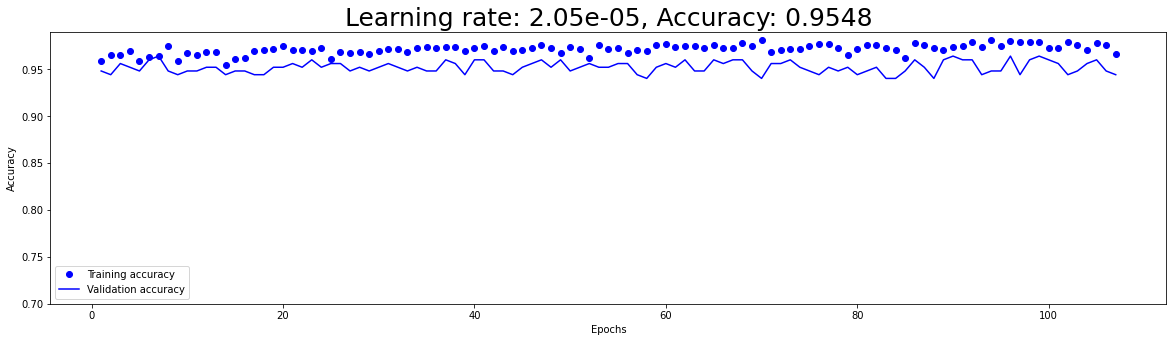

In [70]:
train_and_report(model, lr_list=[2.05e-05], x_train=x_train_list, y_train=y_train, val_data=(x_val_list, y_val), 
                 y_test=y_test, x_test=x_test_list, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=500, verbose=0, patience=100)

In [71]:
model.save('/content/gdrive/MyDrive/pet-transformator/Keras/3.2.CONV1D_4I_acc_0.971.h5')

# **Преобразования рядов**

## **MTF (Markov Transition Fields)**

In [6]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 8.5 MB/s 


In [7]:
!pip install tsia

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import gridspec
from numba import njit, prange
from pyts.image import MarkovTransitionField

import tsia.plot
import tsia.markov
import tsia.network_graph

def get_MTF(x, image_size):
    ''' Возвращает матрицу MTF размерностью (n_samples, image_size, image_size, n_features).

        x - array, матрица временного ряда размерностью (n_samples, n_timestamps, n_features);
        image_size - int, размер окна для ограничения занимаемой памяти, не более n_timestamps.'''

    tag_mtf = np.zeros((x.shape[0], 1, image_size, image_size, x.shape[2]))
    strategy = 'quantile'
    for j in range(x.shape[2]):   
        #for i in range(5):
        for i in range(x.shape[0]):
            X_binned, bin_edges = tsia.markov.discretize (pd.DataFrame(x[i,:,j]))
            X = x[i,:,j].reshape(1, -1)
            mtf = MarkovTransitionField(image_size=image_size, n_bins=len(bin_edges), strategy=strategy)
            tag_mtf[i,:,:,:,j] = mtf.fit_transform(X)
    tag_mtf = tag_mtf[:,0,:,:,:]
    return tag_mtf

In [9]:
x_train_MTF = get_MTF(x_train, int(x_train.shape[1]/4))
x_val_MTF = get_MTF(x_val, int(x_val.shape[1]/4))
x_test_MTF = get_MTF(x_test, int(x_test.shape[1]/4))
print(x_train_MTF.shape, x_val_MTF.shape, x_test_MTF.shape)

(1428, 105, 105, 4) (252, 105, 105, 4) (420, 105, 105, 4)


### Пример

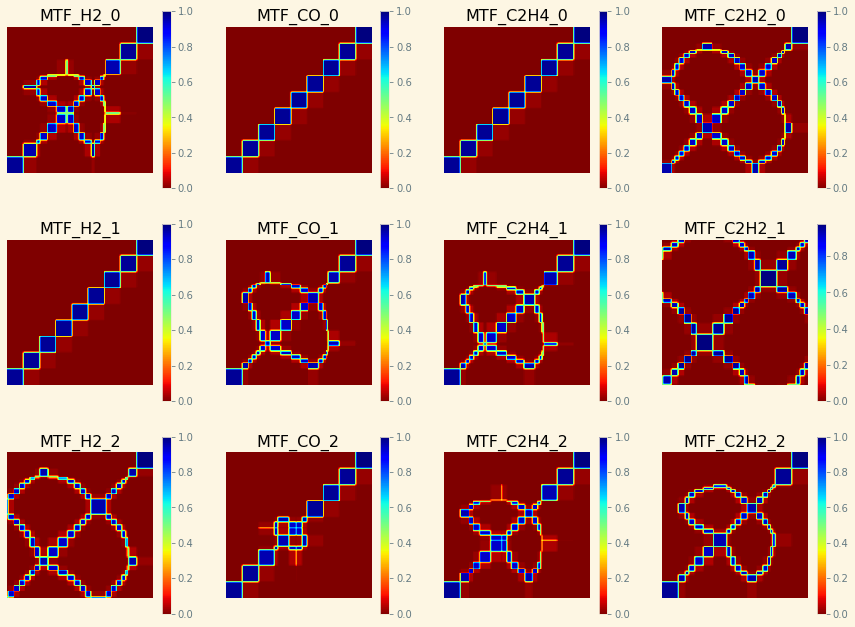

In [ ]:
in_ = x_train_MTF
namelist = ['H2', 'CO', 'C2H4', 'C2H2']
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=4, ncols=in_.shape[3])
b = 0
for i in range(3):   
    for j in range(in_.shape[3]):
        global fig
        global ax
        ax = fig.add_subplot(gs[b])
        _, mappable_image = tsia.plot.plot_markov_transition_field(mtf=in_[i,:,:,j], ax=ax, reversed_cmap=True)
        plt.colorbar(mappable_image)
        ax.set_title(f"MTF_{list(enumerate(namelist))[j][1]}_{i}")
        ax.axis('off')
        b+=1
plt.show()

## **GAF (Gramian Angular Field)**

In [10]:
from pyts.image import GramianAngularField

def get_GAF(x, image_size):
    ''' Возвращает матрицу GAF размерностью (n_samples, image_size, image_size, n_features).

        x - array, матрица временного ряда размерностью (n_samples, n_timestamps, n_features);
        image_size - int, размер окна для ограничения занимаемой памяти, не более n_timestamps.'''

    tag_gaf = np.zeros((x.shape[0], 1, image_size, image_size, x.shape[2]))
    method='summation'
    for j in range(x.shape[2]):   
        #for i in range(5):
        for i in range(x.shape[0]):
            X = x[i,:,j].reshape(1, -1)
            gaf = GramianAngularField(image_size=image_size, method=method)
            tag_gaf[i,:,:,:,j] = gaf.fit_transform(X)
    tag_gaf = tag_gaf[:,0,:,:,:]
    return tag_gaf

In [11]:
x_train_GAF = get_GAF(x_train, int(x_train.shape[1]/4))
x_val_GAF = get_GAF(x_val, int(x_val.shape[1]/4))
x_test_GAF = get_GAF(x_test, int(x_test.shape[1]/4))
print(x_train_GAF.shape, x_val_GAF.shape, x_test_GAF.shape)

(1428, 105, 105, 4) (252, 105, 105, 4) (420, 105, 105, 4)


### Пример

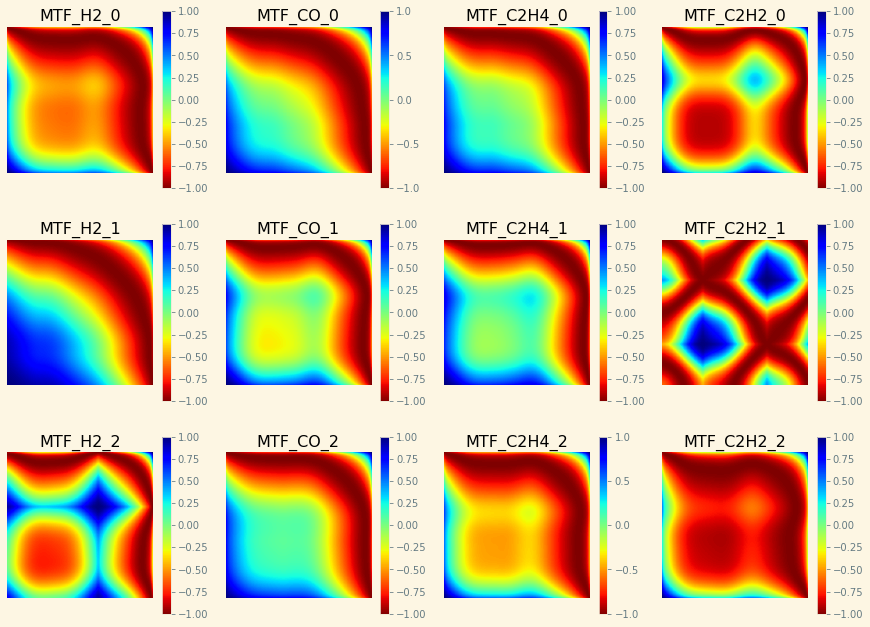

In [ ]:
in_ = x_train_GAF
namelist = ['H2', 'CO', 'C2H4', 'C2H2']
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=4, ncols=in_.shape[3])
b = 0
for i in range(3):   
    for j in range(in_.shape[3]):
        global fig
        global ax
        ax = fig.add_subplot(gs[b])
        _, mappable_image = tsia.plot.plot_markov_transition_field(mtf=in_[i,:,:,j], ax=ax, reversed_cmap=True)
        plt.colorbar(mappable_image)
        ax.set_title(f"MTF_{list(enumerate(namelist))[j][1]}_{i}")
        ax.axis('off')
        b+=1
plt.show()

## **Recurrence plot**

In [12]:
from pyts.image import RecurrencePlot

def get_RP(x, image_size):
    ''' Возвращает матрицу Recurrence Plot размерностью (n_samples, image_size, image_size, n_features).

        x - array, матрица временного ряда размерностью (n_samples, n_timestamps, n_features);
        image_size - int, размер окна для ограничения занимаемой памяти, не более n_timestamps.'''
    tag_rp = np.zeros((x.shape[0], 1, image_size, image_size, x.shape[2]))
    threshold='point'
    for j in range(x.shape[2]):   
        #for i in range(5):
        for i in range(x.shape[0]):
            X = x[i,:,j].reshape(1, -1)
            rp = RecurrencePlot(dimension=0.751)
            tag_rp[i,:,:,:,j] = rp.fit_transform(X)
    tag_rp = tag_rp[:,0,:,:,:]
    return tag_rp

In [13]:
x_train_RP = get_RP(x_train, image_size=int(x_train.shape[1]/4))
x_val_RP = get_RP(x_val, image_size=int(x_val.shape[1]/4))
x_test_RP = get_RP(x_test, image_size=int(x_val.shape[1]/4))
print(x_train_RP.shape, x_val_RP.shape, x_test_RP.shape)

(1428, 105, 105, 4) (252, 105, 105, 4) (420, 105, 105, 4)


### Пример

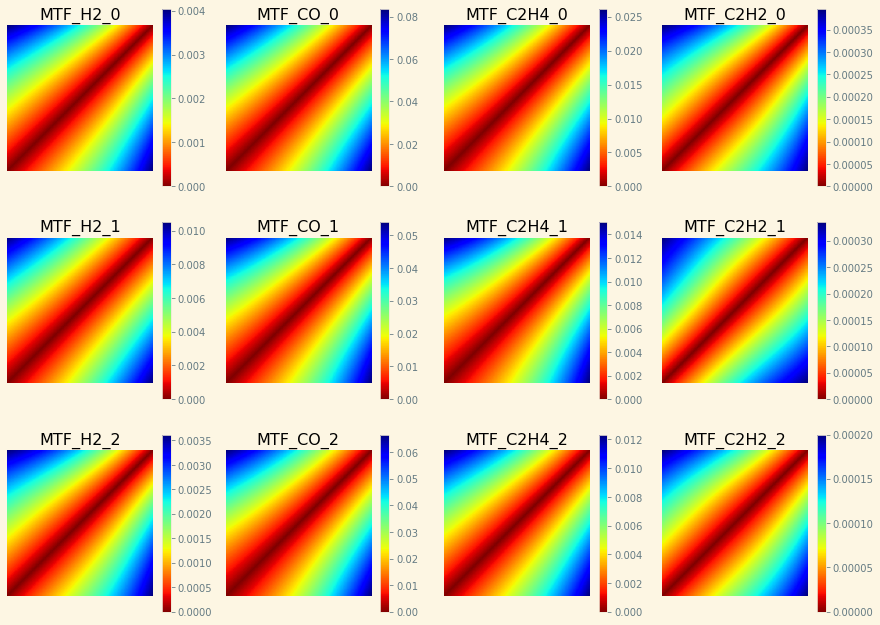

In [ ]:
in_ = x_train_RP
namelist = ['H2', 'CO', 'C2H4', 'C2H2']
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=4, ncols=in_.shape[3])
b = 0
for i in range(3):   
    for j in range(in_.shape[3]):
        global fig
        global ax
        ax = fig.add_subplot(gs[b])
        _, mappable_image = tsia.plot.plot_markov_transition_field(mtf=in_[i,:,:,j], ax=ax, reversed_cmap=True)
        plt.colorbar(mappable_image)
        ax.set_title(f"MTF_{list(enumerate(namelist))[j][1]}_{i}")
        ax.axis('off')
        b+=1
plt.show()

# **CNN1D (Standard, MTF, GAF, RP)**

## **Все преобразования**

In [78]:
filters1 = 32
filters2 = 64
filters3 = 128
kernel_size = 9
pool_size = 2

# Стандартные ряды
h2_input = Input(shape=(420, 1), name='H2')
h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='H2_Conv1')(h2_input)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool1')(h2)
h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='H2_Conv2')(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool2')(h2)
#h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='H2_Conv3')(h2)
#h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool3')(h2)
h2 = layers.Flatten()(h2)
co_input = Input(shape=(420, 1), name='CO')
co = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='CO_Conv1')(co_input)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool1')(co)
co = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='CO_Conv2')(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool2')(co)
#co = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='CO_Conv3')(co)
#co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool3')(co)
co = layers.Flatten()(co)
c2h4_input = Input(shape=(420, 1), name='C2H4')
c2h4 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H4_Conv1')(c2h4_input)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool1')(c2h4)
c2h4 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H4_Conv2')(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool2')(c2h4)
#c2h4 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H4_Conv3')(c2h4)
#c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool3')(c2h4)
c2h4 = layers.Flatten()(c2h4)
c2h2_input = Input(shape=(420, 1), name='C2H2')
c2h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H2_Conv1')(c2h2_input)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool1')(c2h2)
c2h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H2_Conv2')(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool2')(c2h2)
#c2h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H2_Conv3')(c2h2)
#c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool3')(c2h2)
c2h2 = layers.Flatten()(c2h2)

Dense1 = 512
Dense2 = 64

# MTF
h2_MTF_input = Input(shape=(105, 105, 1), name='H2_MTF')
h2_MTF = layers.Flatten(name='H2_MTF_Flatten')(h2_MTF_input)
h2_MTF = layers.Dense(Dense1, activation='relu', name='H2_MTF_Dense1')(h2_MTF)
h2_MTF = layers.Dense(Dense2, activation='relu', name='H2_MTF_Dense2')(h2_MTF)
co_MTF_input = Input(shape=(105, 105, 1), name='CO_MTF')
co_MTF = layers.Flatten(name='CO_MTF_Flatten')(co_MTF_input)
co_MTF = layers.Dense(Dense1, activation='relu', name='CO_MTF_Dense1')(co_MTF)
co_MTF = layers.Dense(Dense2, activation='relu', name='CO_MTF_Dense2')(co_MTF)
c2h4_MTF_input = Input(shape=(105, 105, 1), name='C2H4_MTF')
c2h4_MTF = layers.Flatten(name='C2H4_MTF_Flatten')(c2h4_MTF_input)
c2h4_MTF = layers.Dense(Dense1, activation='relu', name='C2H4_MTF_Dense1')(c2h4_MTF)
c2h4_MTF = layers.Dense(Dense2, activation='relu', name='C2H4_MTF_Dense2')(c2h4_MTF)
c2h2_MTF_input = Input(shape=(105, 105, 1), name='C2H2_MTF')
c2h2_MTF = layers.Flatten(name='C2H2_MTF_Flatten')(c2h2_MTF_input)
c2h2_MTF = layers.Dense(Dense1, activation='relu', name='C2H2_MTF_Dense1')(c2h2_MTF)
c2h2_MTF = layers.Dense(Dense2, activation='relu', name='C2H2_MTF_Dense2')(c2h2_MTF)

# GAF
h2_GAF_input = Input(shape=(105, 105, 1), name='H2_GAF')
h2_GAF = layers.Flatten(name='H2_GAF_Flatten')(h2_GAF_input)
h2_GAF = layers.Dense(Dense1, activation='relu', name='H2_GAF_Dense1')(h2_GAF)
h2_GAF = layers.Dense(Dense2, activation='relu', name='H2_GAF_Dense2')(h2_GAF)
co_GAF_input = Input(shape=(105, 105, 1), name='CO_GAF')
co_GAF = layers.Flatten(name='CO_GAF_Flatten')(co_GAF_input)
co_GAF = layers.Dense(Dense1, activation='relu', name='CO_GAF_Dense1')(co_GAF)
co_GAF = layers.Dense(Dense2, activation='relu', name='CO_GAF_Dense2')(co_GAF)
c2h4_GAF_input = Input(shape=(105, 105, 1), name='C2H4_GAF')
c2h4_GAF = layers.Flatten(name='C2H4_GAF_Flatten')(c2h4_GAF_input)
c2h4_GAF = layers.Dense(Dense1, activation='relu', name='C2H4_GAF_Dense1')(c2h4_GAF)
c2h4_GAF = layers.Dense(Dense2, activation='relu', name='C2H4_GAF_Dense2')(c2h4_GAF)
c2h2_GAF_input = Input(shape=(105, 105, 1), name='C2H2_GAF')
c2h2_GAF = layers.Flatten(name='C2H2_GAF_Flatten')(c2h2_GAF_input)
c2h2_GAF = layers.Dense(Dense1, activation='relu', name='C2H2_GAF_Dense1')(c2h2_GAF)
c2h2_GAF = layers.Dense(Dense2, activation='relu', name='C2H2_GAF_Dense2')(c2h2_GAF)

# RP
h2_RP_input = Input(shape=(105, 105, 1), name='H2_RP')
h2_RP = layers.Flatten(name='H2_RP_Flatten')(h2_RP_input)
h2_RP = layers.Dense(Dense1, activation='relu', name='H2_RP_Dense1')(h2_RP)
h2_RP = layers.Dense(Dense2, activation='relu', name='H2_RP_Dense2')(h2_RP)
co_RP_input = Input(shape=(105, 105, 1), name='CO_RP')
co_RP = layers.Flatten(name='CO_RP_Flatten')(co_RP_input)
co_RP = layers.Dense(Dense1, activation='relu', name='CO_RP_Dense1')(co_RP)
co_RP = layers.Dense(Dense2, activation='relu', name='CO_RP_Dense2')(co_RP)
c2h4_RP_input = Input(shape=(105, 105, 1), name='C2H4_RP')
c2h4_RP = layers.Flatten(name='C2H4_RP_Flatten')(c2h4_RP_input)
c2h4_RP = layers.Dense(Dense1, activation='relu', name='C2H4_RP_Dense1')(c2h4_RP)
c2h4_RP = layers.Dense(Dense2, activation='relu', name='C2H4_RP_Dense2')(c2h4_RP)
c2h2_RP_input = Input(shape=(105, 105, 1), name='C2H2_RP')
c2h2_RP = layers.Flatten(name='C2H2_RP_Flatten')(c2h2_RP_input)
c2h2_RP = layers.Dense(Dense1, activation='relu', name='C2H2_RP_Dense1')(c2h2_RP)
c2h2_RP = layers.Dense(Dense2, activation='relu', name='C2H2_RP_Dense2')(c2h2_RP)

concatenated = layers.concatenate([h2, co, c2h4, c2h2, 
                                   h2_MTF, co_MTF, c2h4_MTF, c2h2_MTF,
                                   h2_GAF, co_GAF, c2h4_GAF, c2h2_GAF,
                                   h2_RP, co_RP, c2h4_RP, c2h2_RP],    
                                  axis=-1) 
x = layers.Dense(5120, activation='relu')(concatenated)
x = layers.Dense(512, activation='relu')(x)
defect = layers.Dense(4, activation='softmax')(x)

model = Model([h2_input, co_input, c2h4_input, c2h2_input, 
               h2_MTF_input, co_MTF_input, c2h4_MTF_input, c2h2_MTF_input,
               h2_GAF_input, co_GAF_input, c2h4_GAF_input, c2h2_GAF_input,
               h2_RP_input, co_RP_input, c2h4_RP_input, c2h2_RP_input
               ], defect)   
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H2 (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 CO (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H4 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H2 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                            

In [79]:
train_list = [x_train[:,:,0]*100, x_train[:,:,1]*100, x_train[:,:,2]*100, x_train[:,:,3]*100, 
              x_train_MTF[:,:,:,0], x_train_MTF[:,:,:,1], x_train_MTF[:,:,:,2], x_train_MTF[:,:,:,3],
              x_train_GAF[:,:,:,0], x_train_GAF[:,:,:,1], x_train_GAF[:,:,:,2], x_train_GAF[:,:,:,3],
              x_train_RP[:,:,:,0], x_train_RP[:,:,:,1], x_train_RP[:,:,:,2], x_train_RP[:,:,:,3]]
val_list = [x_val[:,:,0]*100, x_val[:,:,1]*100, x_val[:,:,2]*100, x_val[:,:,3]*100, 
            x_val_MTF[:,:,:,0], x_val_MTF[:,:,:,1], x_val_MTF[:,:,:,2], x_val_MTF[:,:,:,3],
            x_val_GAF[:,:,:,0], x_val_GAF[:,:,:,1], x_val_GAF[:,:,:,2], x_val_GAF[:,:,:,3],
            x_val_RP[:,:,:,0], x_val_RP[:,:,:,1], x_val_RP[:,:,:,2], x_val_RP[:,:,:,3]] 
test_list = [x_test[:,:,0]*100, x_test[:,:,1]*100, x_test[:,:,2]*100, x_test[:,:,3]*100, 
             x_test_MTF[:,:,:,0], x_test_MTF[:,:,:,1], x_test_MTF[:,:,:,2], x_test_MTF[:,:,:,3],
             x_test_GAF[:,:,:,0], x_test_GAF[:,:,:,1], x_test_GAF[:,:,:,2], x_test_GAF[:,:,:,3],
             x_test_RP[:,:,:,0], x_test_RP[:,:,:,1], x_test_RP[:,:,:,2], x_test_RP[:,:,:,3]]

In [ ]:
loss_changes, learning_rates = Find_Lr(model=model, x_train=train_list, y_train=y_train,
                                                 start_lr=0.000005, end_lr=1, batch_size=32, epochs=100, verbose=1)

In [ ]:
for value in sorted(list(enumerate(loss_changes[0])), key=lambda x: x[1])[:30]:
    print(learning_rates[0][value[0]], end=' ')
    print(f"({value[1]})")

#########################
#########################
Learning_rate: 2.8e-05
--- 327.77394938468933 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       341
           1       0.73      0.89      0.80        18
           2       0.78      0.61      0.68        23
           3       0.75      0.63      0.69        38

    accuracy                           0.93       420
   macro avg       0.80      0.78      0.79       420
weighted avg       0.92      0.93      0.92       420

[[335   0   3   3]
 [  0  16   0   2]
 [  6   0  14   3]
 [  7   6   1  24]]
Accuracy: 0.9262
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       341
           1       0.88      0.78      0.82        18
           2       0.88      0.65      0.75        23
           3       0.81      0.76      0.78        38

    accuracy                           0.9

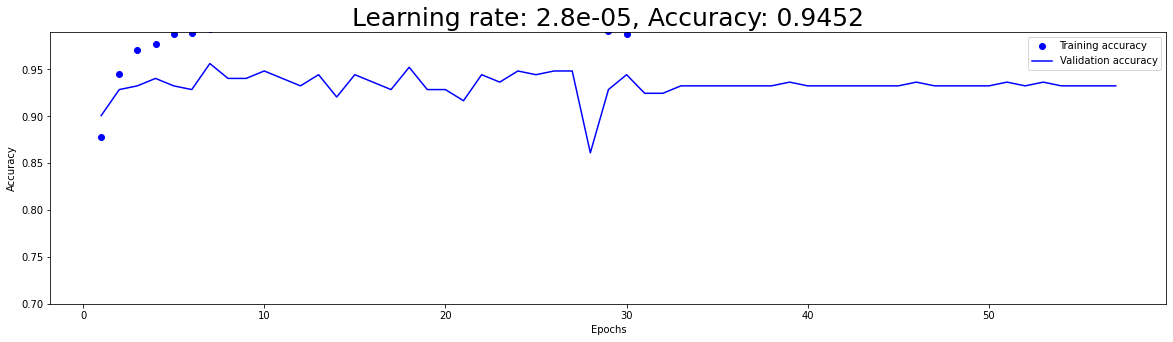

In [80]:
train_and_report(model, lr_list=[2.8e-05], x_train=train_list, y_train=y_train, val_data=(val_list, y_val), 
                 y_test=y_test, x_test=test_list, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=16, epochs=500, verbose=0, patience=50)

In [81]:
model_loaded.save('/content/gdrive/MyDrive/pet-transformator/Keras/3.3.CONV1D(ST+MTF+GAF+RP)_acc_0.9452.h5')

## **Standard+MTF**

In [83]:
train_list = [x_train[:,:,0]*100, x_train[:,:,1]*100, x_train[:,:,2]*100, x_train[:,:,3]*100, 
              x_train_MTF[:,:,:,0], x_train_MTF[:,:,:,1], x_train_MTF[:,:,:,2], x_train_MTF[:,:,:,3],
              ]
val_list = [x_val[:,:,0]*100, x_val[:,:,1]*100, x_val[:,:,2]*100, x_val[:,:,3]*100, 
            x_val_MTF[:,:,:,0], x_val_MTF[:,:,:,1], x_val_MTF[:,:,:,2], x_val_MTF[:,:,:,3],
            ] 
test_list = [x_test[:,:,0]*100, x_test[:,:,1]*100, x_test[:,:,2]*100, x_test[:,:,3]*100, 
             x_test_MTF[:,:,:,0], x_test_MTF[:,:,:,1], x_test_MTF[:,:,:,2], x_test_MTF[:,:,:,3],
             ]

In [92]:
filters1 = 64
filters2 = 128
filters3 = 256
kernel_size = 9
pool_size = 2

# Стандартные ряды
h2_input = Input(shape=(420, 1), name='H2')
h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='H2_Conv1')(h2_input)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool1')(h2)
h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='H2_Conv2')(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool2')(h2)
h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='H2_Conv3')(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool3')(h2)
h2 = layers.Flatten()(h2)
co_input = Input(shape=(420, 1), name='CO')
co = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='CO_Conv1')(co_input)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool1')(co)
co = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='CO_Conv2')(co)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool2')(co)
co = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='CO_Conv3')(co)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool3')(co)
co = layers.Flatten()(co)
c2h4_input = Input(shape=(420, 1), name='C2H4')
c2h4 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H4_Conv1')(c2h4_input)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool1')(c2h4)
c2h4 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H4_Conv2')(c2h4)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool2')(c2h4)
c2h4 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H4_Conv3')(c2h4)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool3')(c2h4)
c2h4 = layers.Flatten()(c2h4)
c2h2_input = Input(shape=(420, 1), name='C2H2')
c2h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H2_Conv1')(c2h2_input)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool1')(c2h2)
c2h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H2_Conv2')(c2h2)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool2')(c2h2)
c2h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H2_Conv3')(c2h2)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool3')(c2h2)
c2h2 = layers.Flatten()(c2h2)

Dense1 = 512
Dense2 = 64

# MTF
h2_MTF_input = Input(shape=(105, 105, 1), name='H2_MTF')
h2_MTF = layers.Flatten(name='H2_MTF_Flatten')(h2_MTF_input)
#h2_MTF = layers.Dropout(0.5)(h2_MTF)
h2_MTF = layers.Dense(Dense1, activation='relu', name='H2_MTF_Dense1')(h2_MTF)
h2_MTF = layers.BatchNormalization()(h2_MTF)
h2_MTF = layers.Dense(Dense2, activation='relu', name='H2_MTF_Dense2')(h2_MTF)
h2_MTF = layers.BatchNormalization()(h2_MTF)
co_MTF_input = Input(shape=(105, 105, 1), name='CO_MTF')
co_MTF = layers.Flatten(name='CO_MTF_Flatten')(co_MTF_input)
#co_MTF = layers.Dropout(0.5)(co_MTF)
co_MTF = layers.Dense(Dense1, activation='relu', name='CO_MTF_Dense1')(co_MTF)
co_MTF = layers.BatchNormalization()(co_MTF)
co_MTF = layers.Dense(Dense2, activation='relu', name='CO_MTF_Dense2')(co_MTF)
co_MTF = layers.BatchNormalization()(co_MTF)
c2h4_MTF_input = Input(shape=(105, 105, 1), name='C2H4_MTF')
c2h4_MTF = layers.Flatten(name='C2H4_MTF_Flatten')(c2h4_MTF_input)
#c2h4_MTF = layers.Dropout(0.5)(c2h4_MTF)
c2h4_MTF = layers.Dense(Dense1, activation='relu', name='C2H4_MTF_Dense1')(c2h4_MTF)
c2h4_MTF = layers.BatchNormalization()(c2h4_MTF)
c2h4_MTF = layers.Dense(Dense2, activation='relu', name='C2H4_MTF_Dense2')(c2h4_MTF)
c2h4_MTF = layers.BatchNormalization()(c2h4_MTF)
c2h2_MTF_input = Input(shape=(105, 105, 1), name='C2H2_MTF')
c2h2_MTF = layers.Flatten(name='C2H2_MTF_Flatten')(c2h2_MTF_input)
#c2h2_MTF = layers.Dropout(0.5)(c2h2_MTF)
c2h2_MTF = layers.Dense(Dense1, activation='relu', name='C2H2_MTF_Dense1')(c2h2_MTF)
c2h2_MTF = layers.BatchNormalization()(c2h2_MTF)
c2h2_MTF = layers.Dense(Dense2, activation='relu', name='C2H2_MTF_Dense2')(c2h2_MTF)
c2h2_MTF = layers.BatchNormalization()(c2h2_MTF)

concatenated = layers.concatenate([h2, co, c2h4, c2h2, 
                                   h2_MTF, co_MTF, c2h4_MTF, c2h2_MTF,
                                  ],    
                                  axis=-1)
#x = layers.Dropout(0.5)(concatenated)
x = layers.Dense(1024, activation='relu')(concatenated)
x = layers.Dense(64, activation='relu')(x)
defect = layers.Dense(4, activation='softmax')(x)

model = Model([h2_input, co_input, c2h4_input, c2h2_input, 
               h2_MTF_input, co_MTF_input, c2h4_MTF_input, c2h2_MTF_input,
               ], defect)   
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H2 (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 CO (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H4 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H2 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                           

#########################
#########################
Learning_rate: 1e-06
--- 331.60471653938293 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       341
           1       0.85      0.61      0.71        18
           2       0.80      0.70      0.74        23
           3       0.71      0.76      0.73        38

    accuracy                           0.93       420
   macro avg       0.83      0.76      0.79       420
weighted avg       0.93      0.93      0.93       420

[[335   0   3   3]
 [  0  11   0   7]
 [  5   0  16   2]
 [  6   2   1  29]]
Accuracy: 0.931
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       341
           1       0.78      0.78      0.78        18
           2       0.86      0.78      0.82        23
           3       0.76      0.74      0.75        38

    accuracy                           0.94  

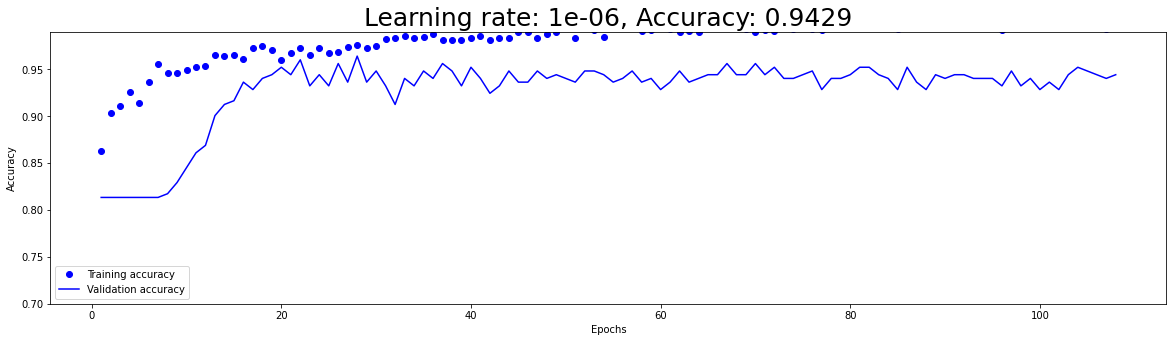

In [93]:
train_and_report(model, lr_list=[1e-06], x_train=train_list, y_train=y_train, val_data=(val_list, y_val), 
                 y_test=y_test, x_test=test_list, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=32, epochs=500, verbose=0, patience=80)

In [94]:
model_loaded.save('/content/gdrive/MyDrive/pet-transformator/Keras/3.4.CONV1D(ST*100+MTF)_acc_0.9429.h5')

## **Standard+GAF**

In [99]:
train_list = [x_train[:,:,0]*100, x_train[:,:,1]*100, x_train[:,:,2]*100, x_train[:,:,3]*100, 
              x_train_GAF[:,:,:,0], x_train_GAF[:,:,:,1], x_train_GAF[:,:,:,2], x_train_GAF[:,:,:,3],
              ]
val_list = [x_val[:,:,0]*100, x_val[:,:,1]*100, x_val[:,:,2]*100, x_val[:,:,3]*100, 
            x_val_GAF[:,:,:,0], x_val_GAF[:,:,:,1], x_val_GAF[:,:,:,2], x_val_GAF[:,:,:,3],
            ] 
test_list = [x_test[:,:,0]*100, x_test[:,:,1]*100, x_test[:,:,2]*100, x_test[:,:,3]*100, 
             x_test_GAF[:,:,:,0], x_test_GAF[:,:,:,1], x_test_GAF[:,:,:,2], x_test_GAF[:,:,:,3],
             ]

In [100]:
filters1 = 64
filters2 = 128
filters3 = 256
kernel_size = 9
pool_size = 2

# Стандартные ряды
h2_input = Input(shape=(420, 1), name='H2')
h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='H2_Conv1')(h2_input)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool1')(h2)
h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='H2_Conv2')(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool2')(h2)
h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='H2_Conv3')(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool3')(h2)
h2 = layers.Flatten()(h2)
co_input = Input(shape=(420, 1), name='CO')
co = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='CO_Conv1')(co_input)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool1')(co)
co = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='CO_Conv2')(co)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool2')(co)
co = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='CO_Conv3')(co)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool3')(co)
co = layers.Flatten()(co)
c2h4_input = Input(shape=(420, 1), name='C2H4')
c2h4 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H4_Conv1')(c2h4_input)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool1')(c2h4)
c2h4 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H4_Conv2')(c2h4)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool2')(c2h4)
c2h4 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H4_Conv3')(c2h4)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool3')(c2h4)
c2h4 = layers.Flatten()(c2h4)
c2h2_input = Input(shape=(420, 1), name='C2H2')
c2h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H2_Conv1')(c2h2_input)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool1')(c2h2)
c2h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H2_Conv2')(c2h2)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool2')(c2h2)
c2h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H2_Conv3')(c2h2)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool3')(c2h2)
c2h2 = layers.Flatten()(c2h2)

Dense1 = 512
Dense2 = 64

# MTF
h2_GAF_input = Input(shape=(105, 105, 1), name='H2_GAF')
h2_GAF = layers.Flatten(name='H2_GAF_Flatten')(h2_GAF_input)
h2_GAF = layers.Dense(Dense1, activation='relu', name='H2_GAF_Dense1')(h2_GAF)
h2_GAF = layers.BatchNormalization()(h2_GAF)
h2_GAF = layers.Dense(Dense2, activation='relu', name='H2_GAF_Dense2')(h2_GAF)
h2_GAF = layers.BatchNormalization()(h2_GAF)
co_GAF_input = Input(shape=(105, 105, 1), name='CO_GAF')
co_GAF = layers.Flatten(name='CO_GAF_Flatten')(co_GAF_input)
co_GAF = layers.Dense(Dense1, activation='relu', name='CO_GAF_Dense1')(co_GAF)
co_GAF = layers.BatchNormalization()(co_GAF)
co_GAF = layers.Dense(Dense2, activation='relu', name='CO_GAF_Dense2')(co_GAF)
co_GAF = layers.BatchNormalization()(co_GAF)
c2h4_GAF_input = Input(shape=(105, 105, 1), name='C2H4_GAF')
c2h4_GAF = layers.Flatten(name='C2H4_GAF_Flatten')(c2h4_GAF_input)
c2h4_GAF = layers.Dense(Dense1, activation='relu', name='C2H4_GAF_Dense1')(c2h4_GAF)
c2h4_GAF = layers.BatchNormalization()(c2h4_GAF)
c2h4_GAF = layers.Dense(Dense2, activation='relu', name='C2H4_GAF_Dense2')(c2h4_GAF)
c2h4_GAF = layers.BatchNormalization()(c2h4_GAF)
c2h2_GAF_input = Input(shape=(105, 105, 1), name='C2H2_GAF')
c2h2_GAF = layers.Flatten(name='C2H2_GAF_Flatten')(c2h2_GAF_input)
c2h2_GAF = layers.Dense(Dense1, activation='relu', name='C2H2_GAF_Dense1')(c2h2_GAF)
c2h2_GAF = layers.BatchNormalization()(c2h2_GAF)
c2h2_GAF = layers.Dense(Dense2, activation='relu', name='C2H2_GAF_Dense2')(c2h2_GAF)
c2h2_GAF = layers.BatchNormalization()(c2h2_GAF)

concatenated = layers.concatenate([h2, co, c2h4, c2h2, 
                                   h2_GAF, co_GAF, c2h4_GAF, c2h2_GAF,
                                  ],    
                                  axis=-1)
#x = layers.Dropout(0.5)(concatenated)
x = layers.Dense(1024, activation='relu')(concatenated)
x = layers.Dense(64, activation='relu')(x)
defect = layers.Dense(4, activation='softmax')(x)

model = Model([h2_input, co_input, c2h4_input, c2h2_input, 
               h2_GAF_input, co_GAF_input, c2h4_GAF_input, c2h2_GAF_input,
               ], defect)   
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H2 (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 CO (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H4 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H2 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                           

#########################
#########################
Learning_rate: 1e-06
--- 327.8603992462158 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       341
           1       0.74      0.94      0.83        18
           2       0.75      0.65      0.70        23
           3       0.79      0.68      0.73        38

    accuracy                           0.93       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.93      0.93      0.93       420

[[332   1   4   4]
 [  0  17   0   1]
 [  6   0  15   2]
 [  6   5   1  26]]
Accuracy: 0.9286
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       341
           1       0.74      0.94      0.83        18
           2       0.85      0.74      0.79        23
           3       0.81      0.66      0.72        38

    accuracy                           0.94  

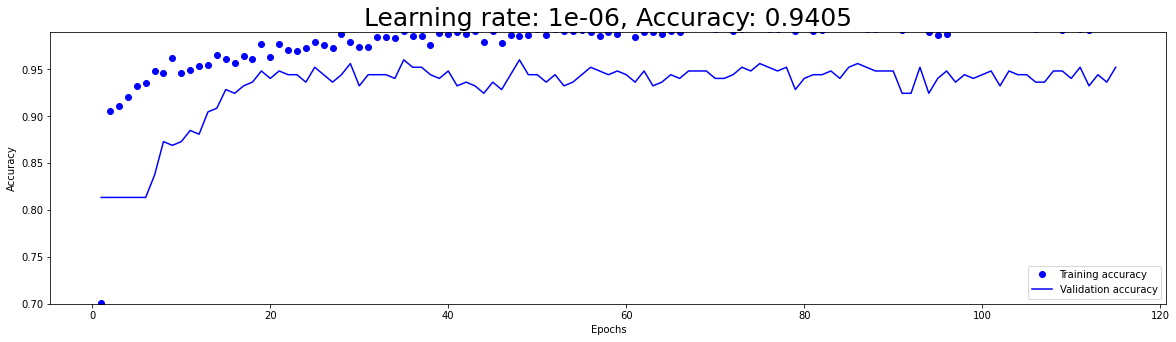

In [101]:
train_and_report(model, lr_list=[1e-06], x_train=train_list, y_train=y_train, val_data=(val_list, y_val), 
                 y_test=y_test, x_test=test_list, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=32, epochs=500, verbose=0, patience=80)

In [103]:
model_loaded.save('/content/gdrive/MyDrive/pet-transformator/Keras/3.5.CONV1D(ST*100+GAF)_acc_0.9405.h5')

## **Standard+PR**

In [105]:
train_list = [x_train[:,:,0]*0.1, x_train[:,:,1]*0.1, x_train[:,:,2]*0.1, x_train[:,:,3]*0.1, 
              x_train_RP[:,:,:,0], x_train_RP[:,:,:,1], x_train_RP[:,:,:,2], x_train_RP[:,:,:,3],
              ]
val_list = [x_val[:,:,0]*0.1, x_val[:,:,1]*0.1, x_val[:,:,2]*0.1, x_val[:,:,3]*0.1, 
            x_val_RP[:,:,:,0], x_val_RP[:,:,:,1], x_val_RP[:,:,:,2], x_val_RP[:,:,:,3],
            ] 
test_list = [x_test[:,:,0]*0.1, x_test[:,:,1]*0.1, x_test[:,:,2]*0.1, x_test[:,:,3]*0.1, 
             x_test_RP[:,:,:,0], x_test_RP[:,:,:,1], x_test_RP[:,:,:,2], x_test_RP[:,:,:,3],
             ]

In [106]:
filters1 = 64
filters2 = 128
filters3 = 256
kernel_size = 9
pool_size = 2

# Стандартные ряды
h2_input = Input(shape=(420, 1), name='H2')
h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='H2_Conv1')(h2_input)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool1')(h2)
h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='H2_Conv2')(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool2')(h2)
h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='H2_Conv3')(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.MaxPooling1D(pool_size=pool_size, name='H2_Pool3')(h2)
h2 = layers.Flatten()(h2)
co_input = Input(shape=(420, 1), name='CO')
co = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='CO_Conv1')(co_input)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool1')(co)
co = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='CO_Conv2')(co)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool2')(co)
co = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='CO_Conv3')(co)
co = layers.BatchNormalization()(co)
co = layers.MaxPooling1D(pool_size=pool_size, name='CO_Pool3')(co)
co = layers.Flatten()(co)
c2h4_input = Input(shape=(420, 1), name='C2H4')
c2h4 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H4_Conv1')(c2h4_input)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool1')(c2h4)
c2h4 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H4_Conv2')(c2h4)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool2')(c2h4)
c2h4 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H4_Conv3')(c2h4)
c2h4 = layers.BatchNormalization()(c2h4)
c2h4 = layers.MaxPooling1D(pool_size=pool_size, name='C2H4_Pool3')(c2h4)
c2h4 = layers.Flatten()(c2h4)
c2h2_input = Input(shape=(420, 1), name='C2H2')
c2h2 = layers.Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', name='C2H2_Conv1')(c2h2_input)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool1')(c2h2)
c2h2 = layers.Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu', name='C2H2_Conv2')(c2h2)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool2')(c2h2)
c2h2 = layers.Conv1D(filters=filters3, kernel_size=kernel_size, activation='relu', name='C2H2_Conv3')(c2h2)
c2h2 = layers.BatchNormalization()(c2h2)
c2h2 = layers.MaxPooling1D(pool_size=pool_size, name='C2H2_Pool3')(c2h2)
c2h2 = layers.Flatten()(c2h2)

Dense1 = 512
Dense2 = 64

# MTF
h2_RP_input = Input(shape=(105, 105, 1), name='H2_RP')
h2_RP = layers.Flatten(name='H2_RP_Flatten')(h2_RP_input)
h2_RP = layers.Dense(Dense1, activation='relu', name='H2_RP_Dense1')(h2_RP)
h2_RP = layers.BatchNormalization()(h2_RP)
h2_RP = layers.Dense(Dense2, activation='relu', name='H2_RP_Dense2')(h2_RP)
h2_RP = layers.BatchNormalization()(h2_RP)
co_RP_input = Input(shape=(105, 105, 1), name='CO_RP')
co_RP = layers.Flatten(name='CO_RP_Flatten')(co_RP_input)
co_RP = layers.Dense(Dense1, activation='relu', name='CO_RP_Dense1')(co_RP)
co_RP = layers.BatchNormalization()(co_RP)
co_RP = layers.Dense(Dense2, activation='relu', name='CO_RP_Dense2')(co_RP)
co_RP = layers.BatchNormalization()(co_RP)
c2h4_RP_input = Input(shape=(105, 105, 1), name='C2H4_RP')
c2h4_RP = layers.Flatten(name='C2H4_RP_Flatten')(c2h4_RP_input)
c2h4_RP = layers.Dense(Dense1, activation='relu', name='C2H4_RP_Dense1')(c2h4_RP)
c2h4_RP = layers.BatchNormalization()(c2h4_RP)
c2h4_RP = layers.Dense(Dense2, activation='relu', name='C2H4_RP_Dense2')(c2h4_RP)
c2h4_RP = layers.BatchNormalization()(c2h4_RP)
c2h2_RP_input = Input(shape=(105, 105, 1), name='C2H2_RP')
c2h2_RP = layers.Flatten(name='C2H2_RP_Flatten')(c2h2_RP_input)
c2h2_RP = layers.Dense(Dense1, activation='relu', name='C2H2_RP_Dense1')(c2h2_RP)
c2h2_RP = layers.BatchNormalization()(c2h2_RP)
c2h2_RP = layers.Dense(Dense2, activation='relu', name='C2H2_RP_Dense2')(c2h2_RP)
c2h2_RP = layers.BatchNormalization()(c2h2_RP)

concatenated = layers.concatenate([h2, co, c2h4, c2h2, 
                                   h2_RP, co_RP, c2h4_RP, c2h2_RP,
                                  ],    
                                  axis=-1)
#x = layers.Dropout(0.5)(concatenated)
x = layers.Dense(1024, activation='relu')(concatenated)
x = layers.Dense(64, activation='relu')(x)
defect = layers.Dense(4, activation='softmax')(x)

model = Model([h2_input, co_input, c2h4_input, c2h2_input, 
               h2_RP_input, co_RP_input, c2h4_RP_input, c2h2_RP_input,
               ], defect)   
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 H2 (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 CO (InputLayer)                [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H4 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                                  
 C2H2 (InputLayer)              [(None, 420, 1)]     0           []                               
                                                                                           

#########################
#########################
Learning_rate: 1e-06
--- 388.5280849933624 seconds ---
Last epoch (model):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       341
           1       0.78      1.00      0.88        18
           2       0.86      0.78      0.82        23
           3       0.75      0.71      0.73        38

    accuracy                           0.94       420
   macro avg       0.84      0.87      0.85       420
weighted avg       0.94      0.94      0.94       420

[[332   0   2   7]
 [  0  18   0   0]
 [  3   0  18   2]
 [  5   5   1  27]]
Accuracy: 0.9405
Best epoch (model_loaded):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       341
           1       0.81      0.94      0.87        18
           2       0.76      0.83      0.79        23
           3       0.77      0.71      0.74        38

    accuracy                           0.94  

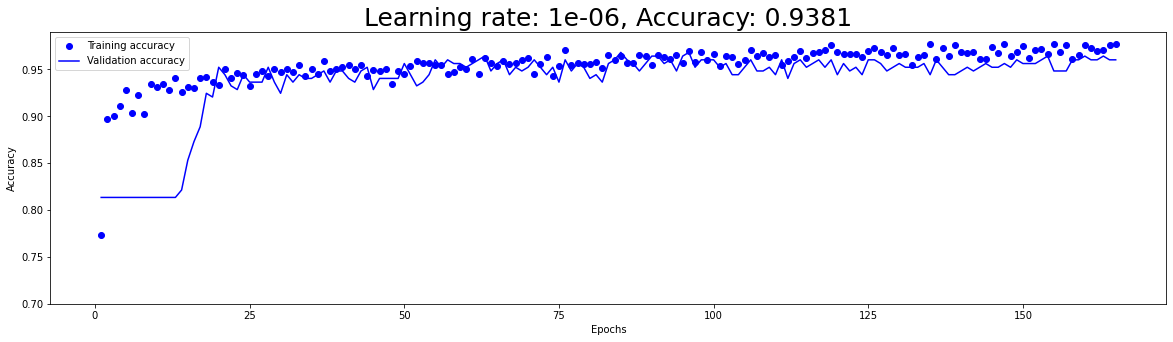

In [107]:
train_and_report(model, lr_list=[1e-06], x_train=train_list, y_train=y_train, val_data=(val_list, y_val), 
                 y_test=y_test, x_test=test_list, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=32, epochs=500, verbose=0, patience=80)

In [108]:
model.save('/content/gdrive/MyDrive/pet-transformator/Keras/3.6.CONV1D(ST*0.1+RP)_acc_0.9405.h5')